# Programmable illumination: phase contrast

_Srayan Gangopadhyay_  
_Thu 9 Mar 2023_

Sources:
- https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle
- https://stackoverflow.com/questions/38674027/find-the-row-indexes-of-several-values-in-a-numpy-array

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2
from led_posns import *

To do:
- [X] Combine all images into single stack
- [X] Rescale all images
- [X] Find centre LED using max brightness
- [ ] ~~Find rotation using max brightness~~


## Simulating the LED setup to get the required indices

## Reading in the images

In [33]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-13'
background = io.imread(img_dir + r'\2023-03-13 background fd 16b16.tif')
phantom = io.imread(img_dir + r'\2023-03-13 broken phantom fd 16b16.tif')

phantom -= background

In [34]:
phantom.shape

(256, 1392, 1040)

In [35]:
phantom = np.reshape(phantom, (16, 16, 1392, 1040))

In [36]:
len(phantom)

16

In [37]:
# # normalise all images - WHY DOESN'T THIS WORK PROPERLY?
# for a in phantom:
#     a = (255*(a - np.min(a))/np.ptp(a)).astype(int)

If we crop by one pixel on each side, our array dimensions are now odd (`(15, 15)`) - so how do we split our left-right, top-bottom phase gradient images? Do we reuse the middle rows e.g., split `[0, 1, 2, 3, 4]` into `[0, 1, 2]` and `[2, 3, 4]`?

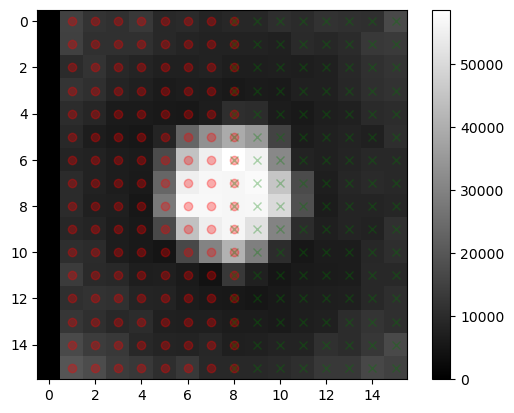

In [38]:
brightnesses = np.zeros((16, 16))

for i in range(16):
    for j in range(16):
        if j != 0:
            brightnesses[i, j] = np.mean(phantom[i][j])
            if j <= 8:
                plt.plot(j, i, 'o', color='red', alpha=0.3)
            if j >= 8:
                plt.plot(j, i, 'x', color='green', alpha=0.3)
    
plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

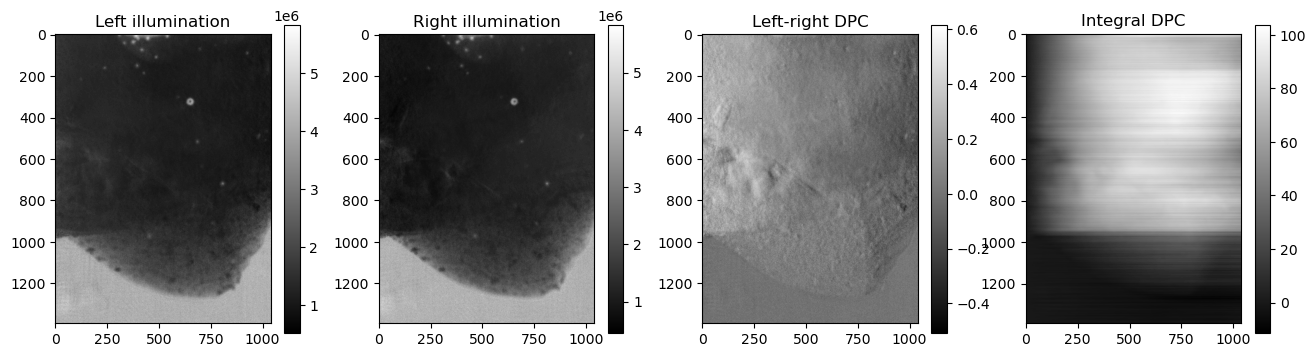

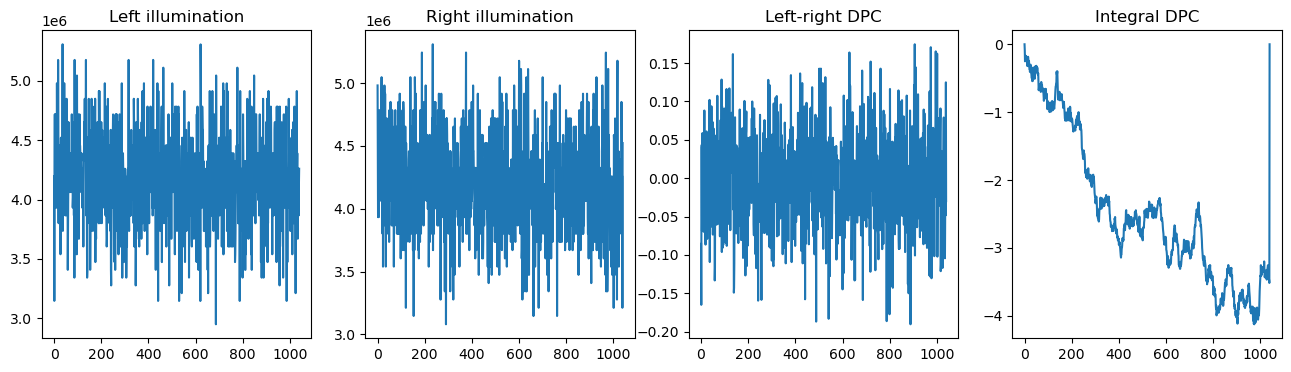

In [49]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))


for i in range(16):
    for j in range(16):
        if j != 0:
            if j <= 8:
                left += phantom[i][j]
            if j >= 8:
                right += phantom[i][j]
                
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
mpbl = axs[2].imshow(lr_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1039))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

mpbl = axs[3].imshow(lr_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()



fig, axs = plt.subplots(1, 4, figsize=(16, 4))

row_to_plot = 1350

axs[0].plot(left[row_to_plot, :])
axs[0].set_title('Left illumination')
axs[1].plot(right[row_to_plot, :])
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
axs[2].plot(lr_phsgrd[row_to_plot, :])
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1040))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

axs[3].plot(lr_integral[row_to_plot, :])
axs[3].set_title('Integral DPC')
plt.show()

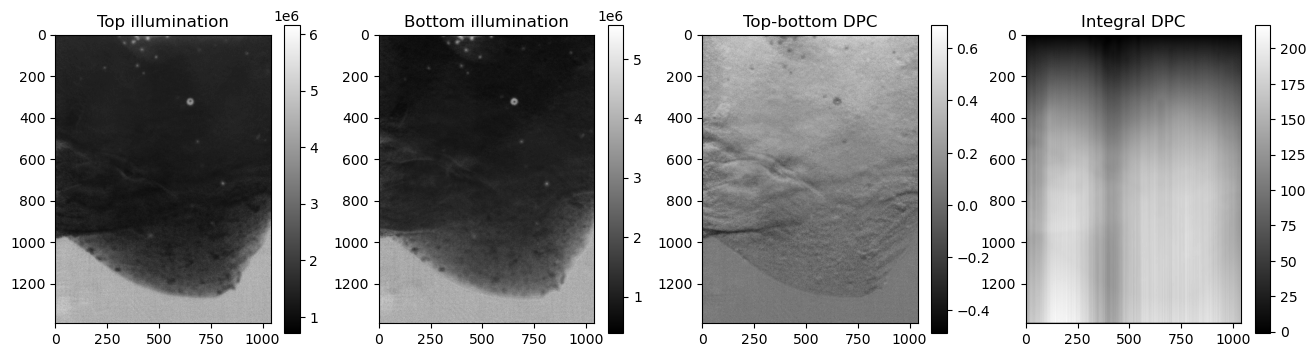

In [45]:
top = np.zeros((1392, 1040))
bottom = np.zeros((1392, 1040))

for i in range(16):
    for j in range(16):
        if j != 0:
            if i <= 8:
                top += phantom[i][j]
            if i >= 8:
                bottom += phantom[i][j]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
tb_phsgrd = (top-bottom)/(top+bottom)
mpbl = axs[2].imshow(tb_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')

tb_integral = np.zeros((1392, 1040))
for i in range(tb_phsgrd.shape[0]-1):
    tb_integral[i, :] = np.sum(tb_phsgrd[:i, :], axis=0)

mpbl = axs[3].imshow(tb_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()

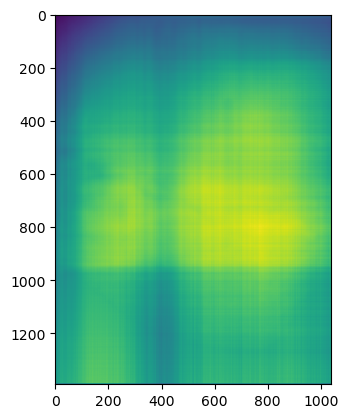

In [47]:
plt.imshow(tb_integral+lr_integral)

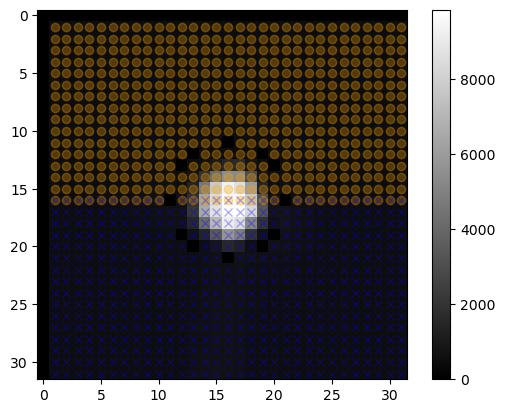

In [14]:
brightnesses = np.zeros((32, 32))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        brightnesses[coord[0], coord[1]] = np.mean(img)
        if coord[1] <= 16:
            plt.plot(coord[0], coord[1], 'o', color='orange', alpha=0.3)
        if coord[1] >= 16:
            plt.plot(coord[0], coord[1], 'x', color='blue', alpha=0.3)
    
plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

## Corrected phase contrast images

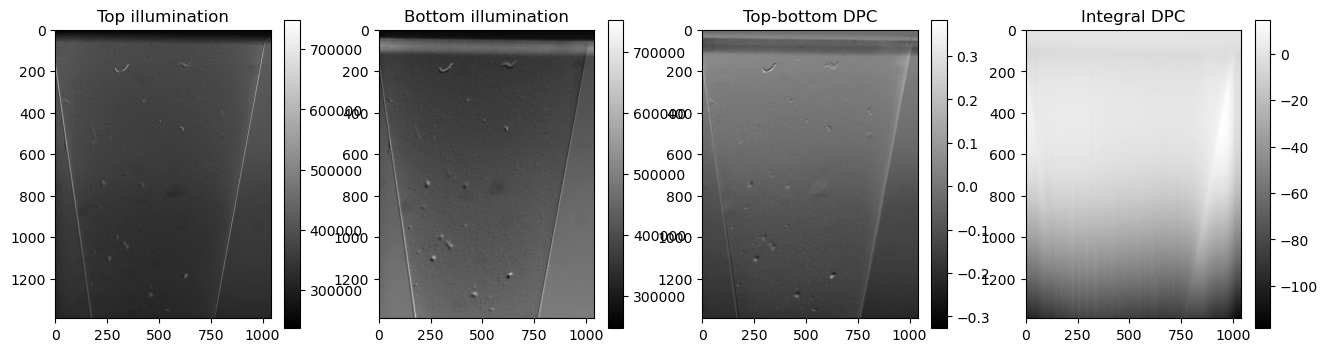

In [25]:
top = np.zeros((1392, 1040))
bottom = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[0] <= 16:
            top += img
        if coord[0] >= 16:
            bottom += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
tb_phsgrd = (top-bottom)/(top+bottom)
mpbl = axs[2].imshow(tb_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')

tb_integral = np.zeros((1391, 1040))
for i in range(tb_phsgrd.shape[0]-1):
    tb_integral[i, :] = np.sum(tb_phsgrd[:i, :], axis=0)

mpbl = axs[3].imshow(tb_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()

In [20]:
tb_phsgrd.shape

(1392, 1040)

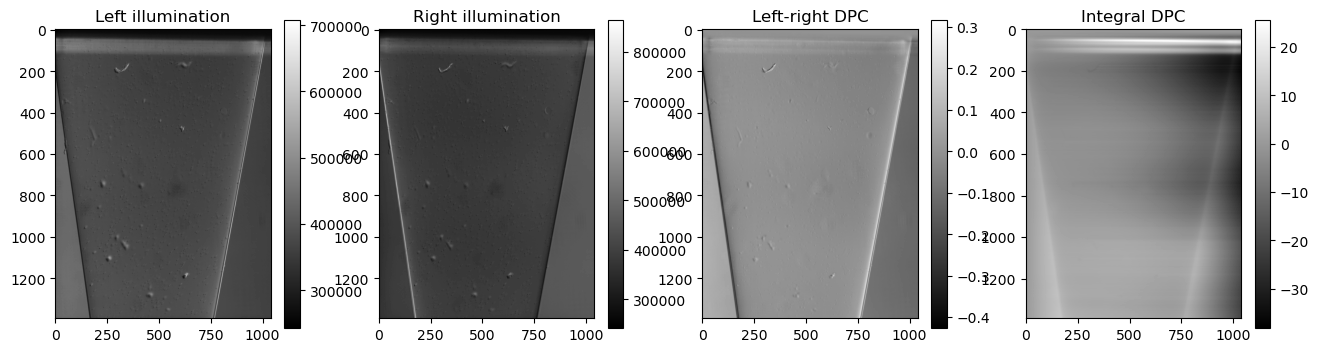

In [28]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[1] <= 16:
            left += img
        if coord[1] >= 16:
            right += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
mpbl = axs[2].imshow(lr_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1039))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

mpbl = axs[3].imshow(lr_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()

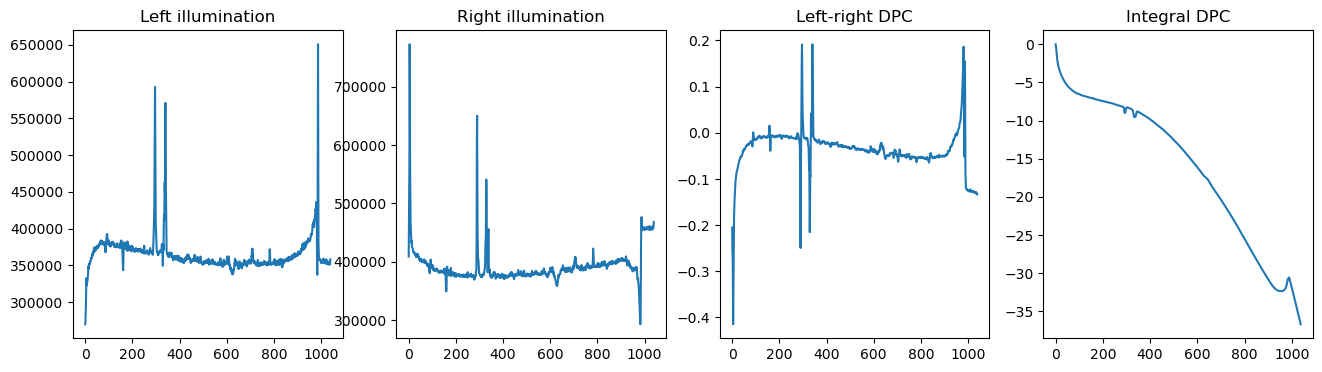

In [29]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[1] <= 16:
            left += img
        if coord[1] >= 16:
            right += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))


axs[0].plot(left[190, :])
axs[0].set_title('Left illumination')
axs[1].plot(right[190, :])
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
axs[2].plot(lr_phsgrd[190, :])
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1039))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

axs[3].plot(lr_integral[190, :])
axs[3].set_title('Integral DPC')
plt.show()

---

## OLD: Calculating the phase contrast images
_This is prior to the discovery of problems with alignment and missing images._

Assuming $I_{DPC} = \frac{I_L - I_R}{I_L + I_R}$ (from [here](https://doi.org/10.1371/journal.pone.0124938))

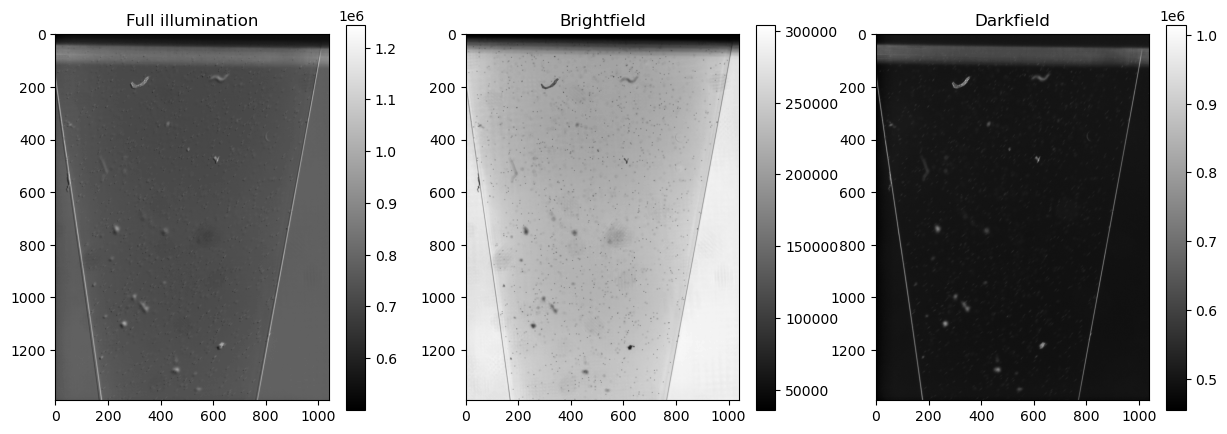

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(np.sum(np.concatenate((brightfield, darkfield)), axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Full illumination')
mpbl = axs[1].imshow(np.sum(brightfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Brightfield')
mpbl = axs[2].imshow(np.sum(darkfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Darkfield')
plt.show()

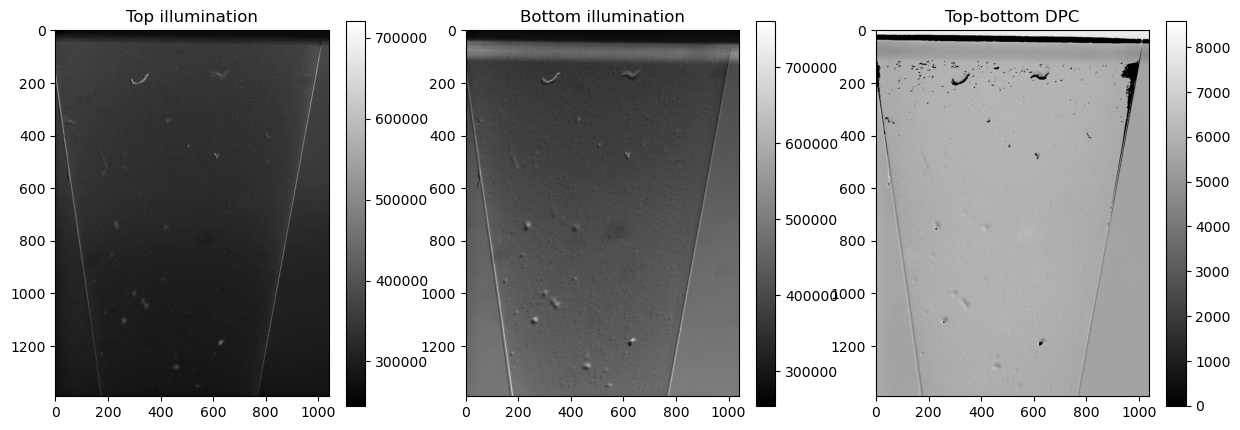

In [12]:
top = np.sum(np.concatenate((brightfield[XinY(top_posns, bright_posns)], darkfield[XinY(top_posns, dark_posns)])), axis=0)
bottom = np.sum(np.concatenate((brightfield[XinY(bottom_posns, bright_posns)], darkfield[XinY(bottom_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
mpbl = axs[2].imshow((top-bottom)/(top+bottom), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')
plt.show()

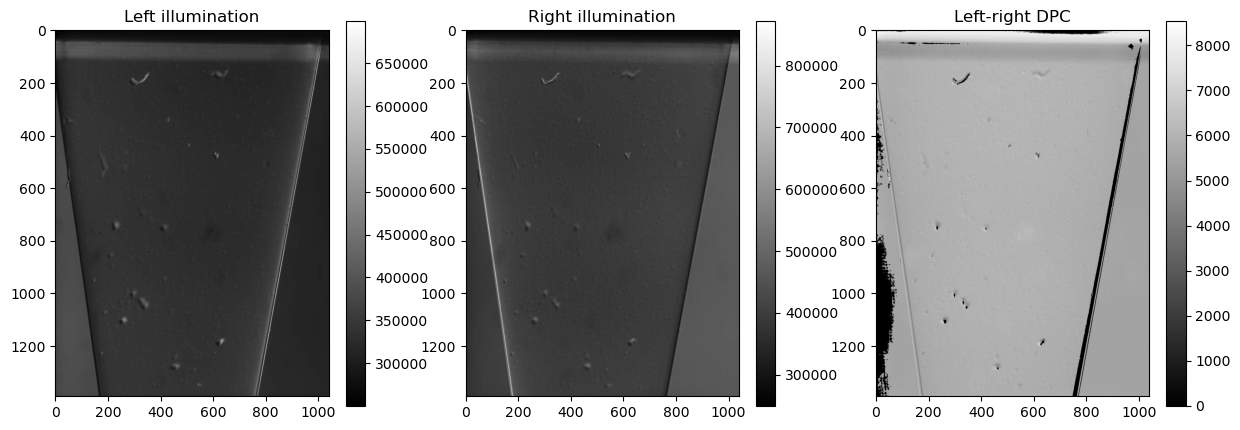

In [13]:
left = np.sum(np.concatenate((brightfield[XinY(left_posns, bright_posns)], darkfield[XinY(left_posns, dark_posns)])), axis=0)
right = np.sum(np.concatenate((brightfield[XinY(right_posns, bright_posns)], darkfield[XinY(right_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
mpbl = axs[2].imshow((left-right)/(left+right), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')
plt.show()

## Digital refocusing

$I^{\Delta Z} = \Sigma I_i(x + \Delta z \tan{\theta_x}, y + \Delta z \tan{\theta_y})$, where $\tan{\theta_x} = \frac{\Delta x}{L} = \frac{(16-i) \times 4 mm}{L}$ and $\tan{\theta_y} = \frac{(j-16) \times 4 mm}{L}$, if we define x upwards and y to the right of the central LED (since (0,0) is top-left). 

TODO: measure L  
NOTE: effect of water on k-vector?

In [99]:
def shift_image(image, x_shift_mm, y_shift_mm):
    """
    Return translated image, given x and y shifts in mm,
    assuming a pixel size of 6.45um
    """
    x_shift_px = x_shift_mm / 6.45e-3
    y_shift_px = y_shift_mm / 6.45e-3
    
    M = np.float32([
        [1, 0, x_shift_px],
        [0, 1, y_shift_px]
    ])
    
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


def required_shifts(i, j, delta_z, L=355):
    """
    Calculated required shifts in mm given LED coordinates
    and required refocus distance delta_z, assuming a 32x32
    LED array with pitch 4mm, with LED (16, 16) centred on 
    the optical axis, and with (0, 0) at the top left.
    """
    delta_x = (16-i) * 4
    tan_theta_x = delta_x / L
    x_shift_mm = delta_z * tan_theta_x
    
    delta_y = (j-16) * 4
    tan_theta_y = delta_y / L
    y_shift_mm = delta_z * tan_theta_y
    
    
    return x_shift_mm, y_shift_mm


def refocus_img(all_posns, all_imgs, delta_z):
    refocused = np.zeros((all_imgs.shape[1], all_imgs.shape[2]))
    for coord, img in zip(all_posns, all_imgs):
        x_shift_mm, y_shift_mm = required_shifts(coord[0], coord[1], delta_z)
        refocused += shift_image(img, x_shift_mm, y_shift_mm)
    return refocused

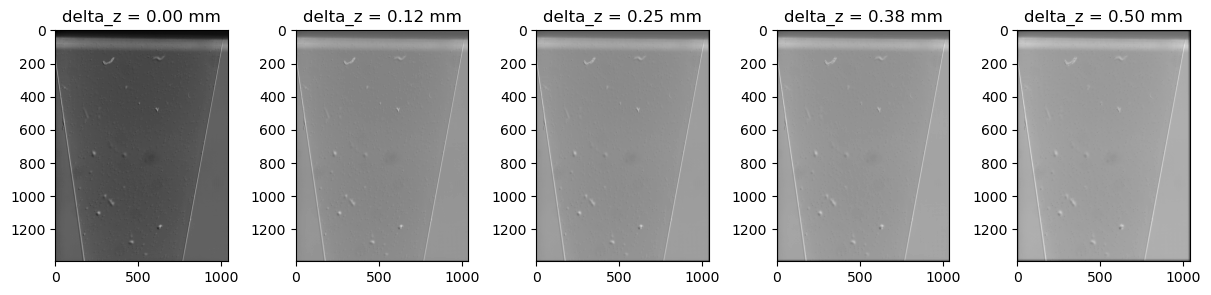

In [100]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, shift in zip(range(5), np.linspace(0, 0.5, 5)):
    axs[i].imshow(refocus_img(all_posns, all_imgs, shift), cmap='gray')
    axs[i].set_title(f'delta_z = {shift:.2f} mm')